In [1]:
import utils
import plotting
import postprocessing
import corrections

from utils import CUT_MAX_VAL, ShapeVar
from HHbbVV.hh_vars import (
    years,
    data_key,
    qcd_key,
    bg_keys,
    samples,
    nonres_sig_keys,
    nonres_samples,
    txbb_wps,
    jec_shifts,
    jmsr_shifts,
    LUMI,
)
from postprocessing import res_shape_vars, load_filters

from collections import OrderedDict

import numpy as np
import pandas as pd
import pickle, json
import hist
from hist import Hist

import os
from pathlib import Path
from copy import deepcopy
from inspect import cleandoc
import warnings

# suppress warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime

MAIN_DIR = Path("../../../")
samples_dir = MAIN_DIR / "../data/skimmer/24Mar5AllYears"
# samples_dir = "/ceph/cms/store/user/annava/projects/HHbbVV/24Mar5AllYears"
year = "2016"

# date = "24Mar6"
date = datetime.now().strftime("%Y%m%d")
plot_dir = MAIN_DIR / f"plots/PostProcessing/{date}/"
templates_dir = Path(f"templates/{date}/")

_ = os.system(f"mkdir -p {plot_dir}/ControlPlots/{year}")
_ = os.system(f"mkdir -p {plot_dir}/cutflows")
_ = os.system(f"mkdir -p {plot_dir}/templates/wshifts")
_ = os.system(f"mkdir -p {plot_dir}/templates/jshifts")
_ = os.system(f"mkdir -p {plot_dir}/templates/hists2d")
_ = os.system(f"mkdir -p {templates_dir}/cutflows/{year}")

Load samples

In [4]:
systematics = {year: {}}

# save cutflow as pandas table
cutflow = pd.DataFrame(index=list(samples.keys()) + list(nonres_samples.keys()))

events_dict = postprocessing.load_samples(
    data_dir=samples_dir,
    samples={**nonres_samples, **samples},
    year=year,
    filters=load_filters,  # Both Jet's Regressed Mass above 50
)

Loaded GluGluToHHTobbVV_node_cHHH1                       : 89570 entries
Loaded GluGluToHHTobbVV_node_cHHH2p45                    : 144870 entries
Loaded GluGluToHHTobbVV_node_cHHH5                       : 20708 entries
Loaded GluGluToHHTobbVV_node_cHHH0                       : 73323 entries
Loaded VBF_HHTobbVV_CV_1_C2V_1_C3_1                      : 10444 entries
Loaded VBF_HHTobbVV_CV_1_C2V_0_C3_1                      : 236901 entries
Loaded VBF_HHTobbVV_CV_1_5_C2V_1_C3_1                    : 151258 entries
Loaded VBF_HHTobbVV_CV_1_C2V_1_C3_2                      : 12584 entries
Loaded VBF_HHTobbVV_CV_1_C2V_2_C3_1                      : 402661 entries
Loaded VBF_HHTobbVV_CV_1_C2V_1_C3_0                      : 10259 entries
Loaded QCD_HT300to500                                    : 9 entries
Loaded QCD_HT700to1000                                   : 91009 entries
Loaded QCD_HT1000to1500                                  : 53037 entries
Loaded QCD_HT2000toInf                             

In [5]:
utils.add_to_cutflow(
    events_dict=events_dict, key="Preselection", weight_key="finalWeight", cutflow=cutflow
)
cutflow

,Preselection
QCD,7.179862e+05
TT,6.312681e+04
ST,5.417825e+03
W+Jets,9.487889e+03
Z+Jets,1.205582e+04
Diboson,5.447515e+02
ggFHbb,1.207420e+02
VBFHbb,3.224173e+01
ZHbb,3.270020e+01
WHbb,5.601432e+01


Scale factors and bb VV assignment

In [6]:
# Apply QCD scale factors
postprocessing.qcd_sf(events_dict, cutflow)
# Create a dataframe of masks for extracting the bb or VV candidates.
# bb candidate is chosen based on higher Txbb score.
bb_masks = postprocessing.bb_VV_assignment(events_dict)
# Add Dijet variables
postprocessing.derive_variables(events_dict=events_dict, bb_masks=bb_masks, nonres_vars=False)
cutflow


QCD_SCALE_FACTOR = 1.3520006261083493


,Preselection,QCD SF
QCD,7.179862e+05,9.707178e+05
TT,6.312681e+04,6.312681e+04
ST,5.417825e+03,5.417825e+03
W+Jets,9.487889e+03,9.487889e+03
Z+Jets,1.205582e+04,1.205582e+04
Diboson,5.447515e+02,5.447515e+02
ggFHbb,1.207420e+02,1.207420e+02
VBFHbb,3.224173e+01,3.224173e+01
ZHbb,3.270020e+01,3.270020e+01
WHbb,5.601432e+01,5.601432e+01


Control Plots

[ShapeVar(var='bbFatJetParticleNetMass', label='$m^{bb}_{reg}$ (GeV)', bins=[20, 50, 250], reg=True, blind_window=None, significance_dir='bin'), ShapeVar(var='bbFatJetMsd', label='$m^{bb}_{msd}$ (GeV)', bins=[20, 0, 300], reg=True, blind_window=None, significance_dir='right'), ShapeVar(var='bbFatJetPt', label='$p^{bb}_T$ (GeV)', bins=[20, 300, 2300], reg=True, blind_window=None, significance_dir='right'), ShapeVar(var='bbFatJetEta', label='$\\eta^{bb}$', bins=[20, -2.4, 2.4], reg=True, blind_window=None, significance_dir='right'), ShapeVar(var='bbFatJetParticleNetMD_Txbb', label='$T^{bb}_{Xbb}$', bins=[50, 0.8, 1], reg=True, blind_window=None, significance_dir='right'), ShapeVar(var='VVFatJetParticleNetMass', label='$m^{VV}_{reg}$ (GeV)', bins=[20, 50, 250], reg=True, blind_window=None, significance_dir='right'), ShapeVar(var='VVFatJetMsd', label='$m^{VV}_{msd}$ (GeV)', bins=[40, 50, 250], reg=True, blind_window=None, significance_dir='right'), ShapeVar(var='VVFatJetEta', label='$\\eta

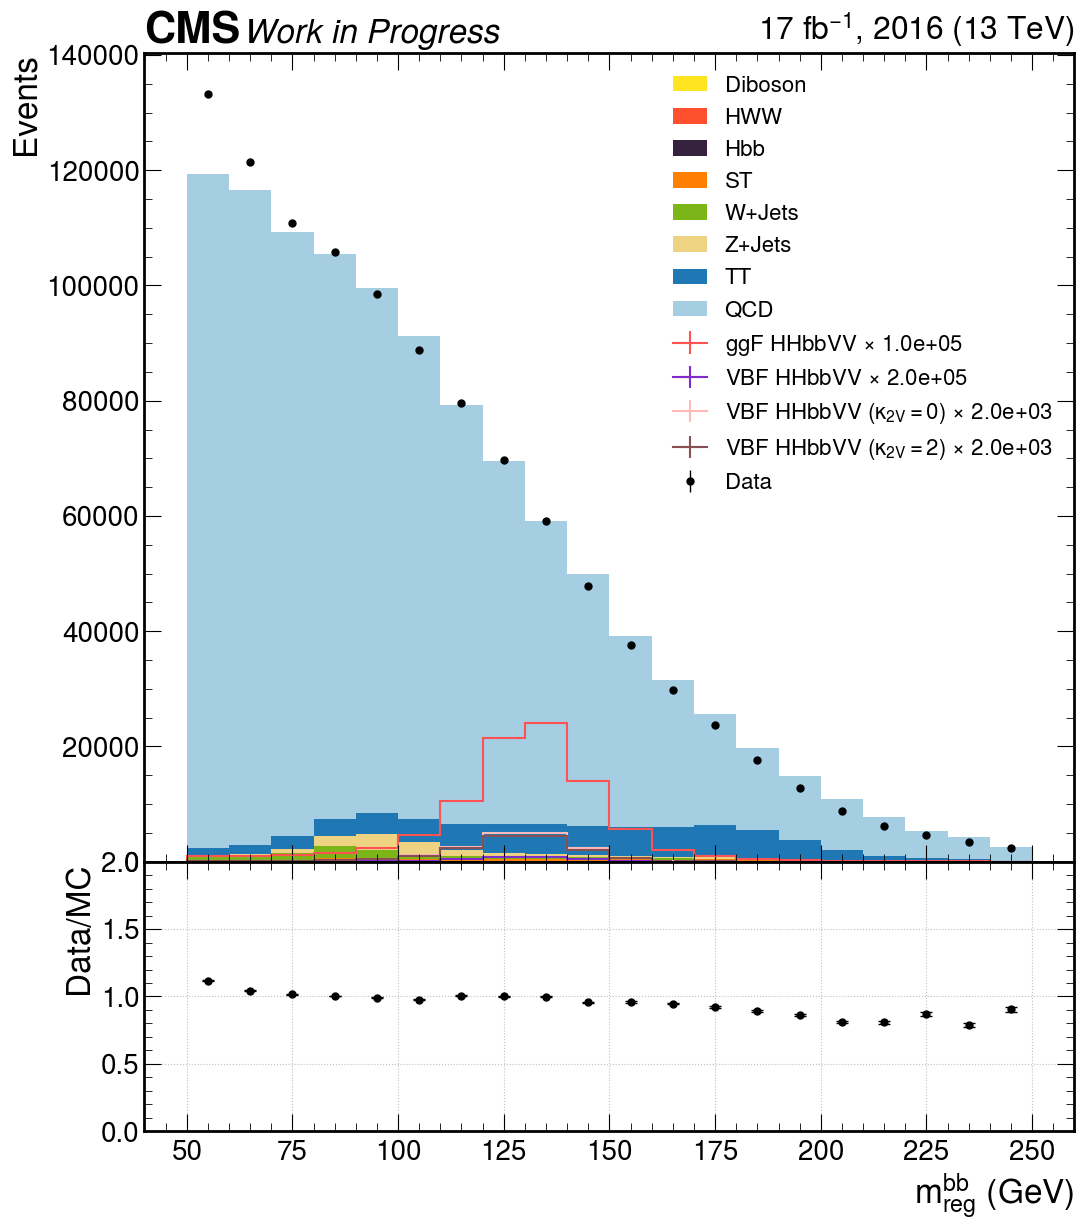

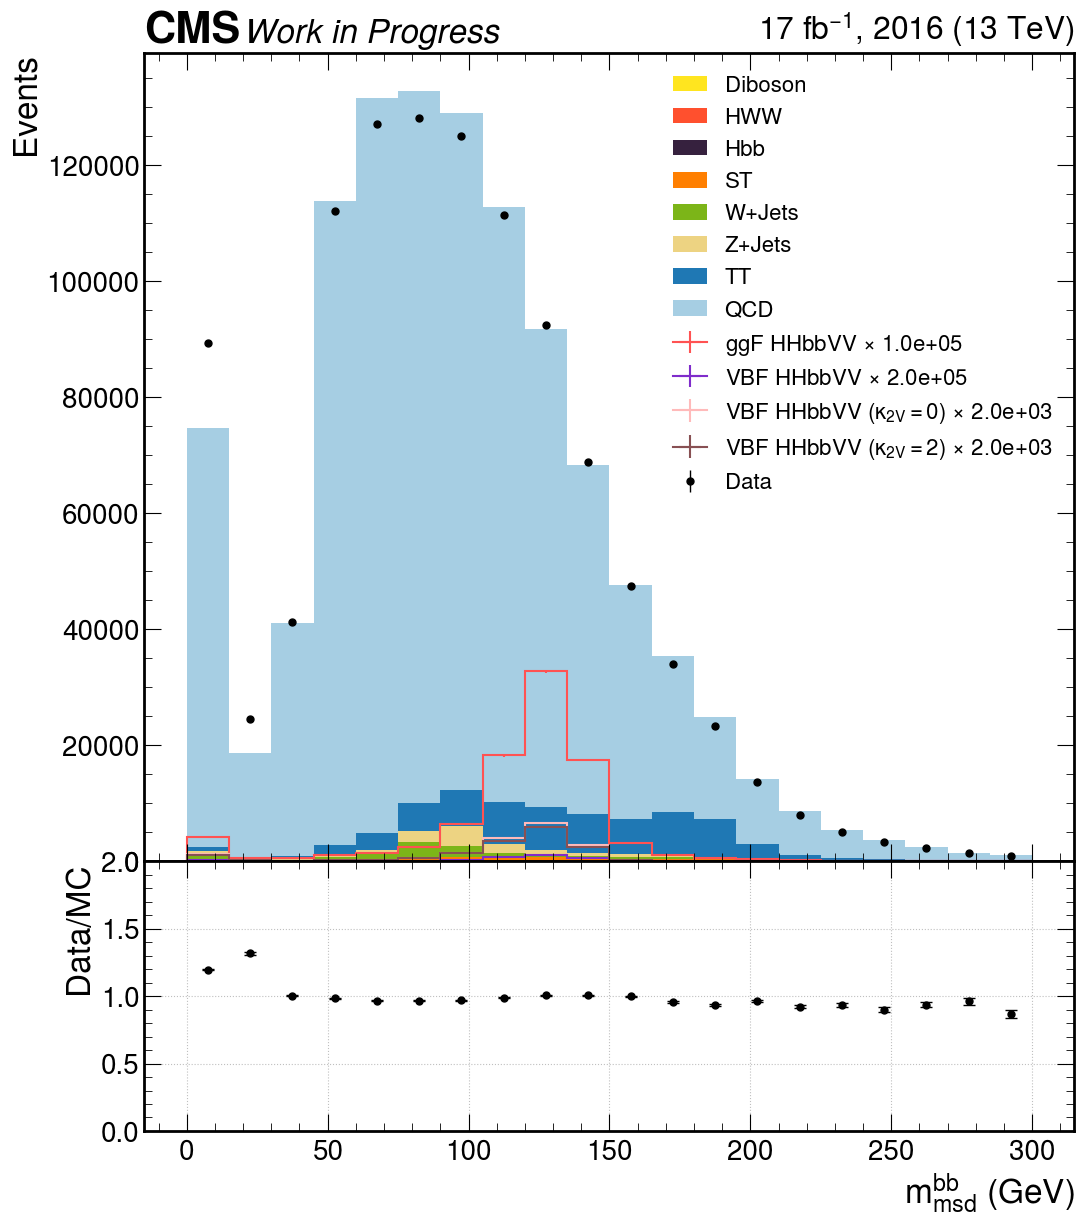

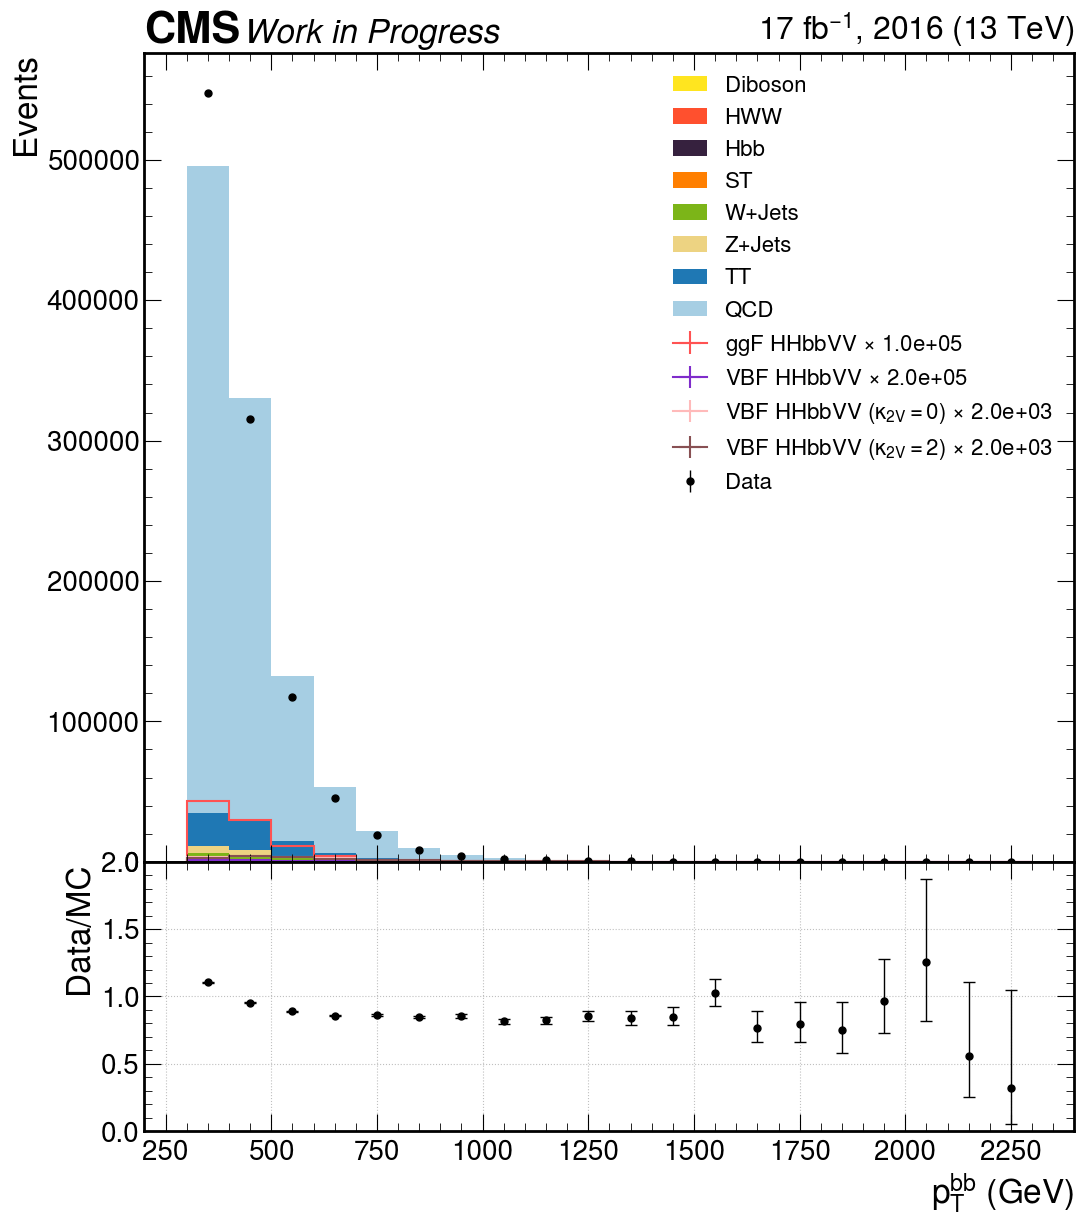

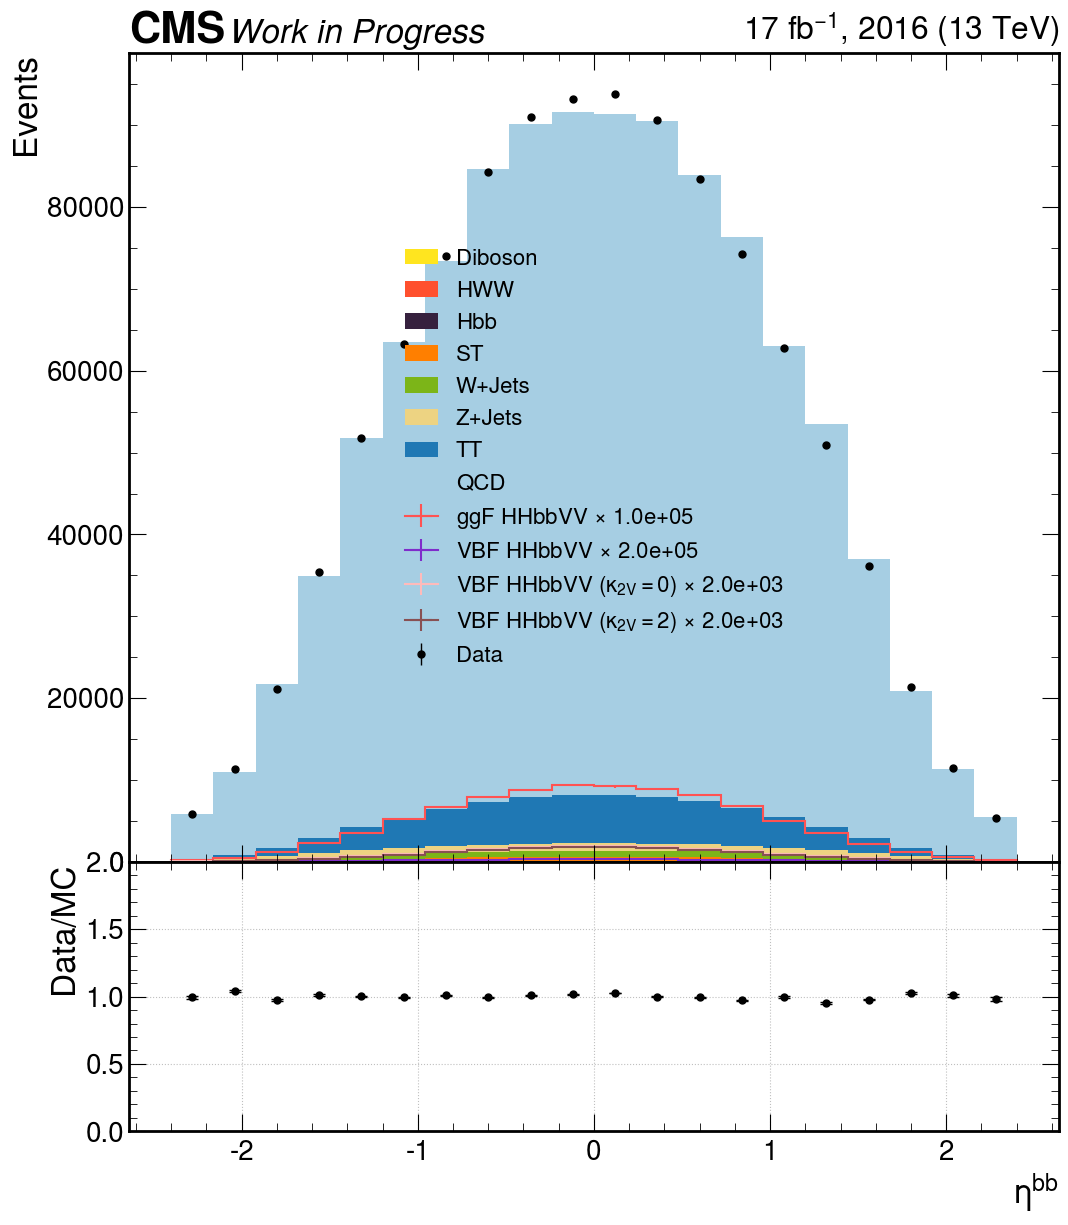

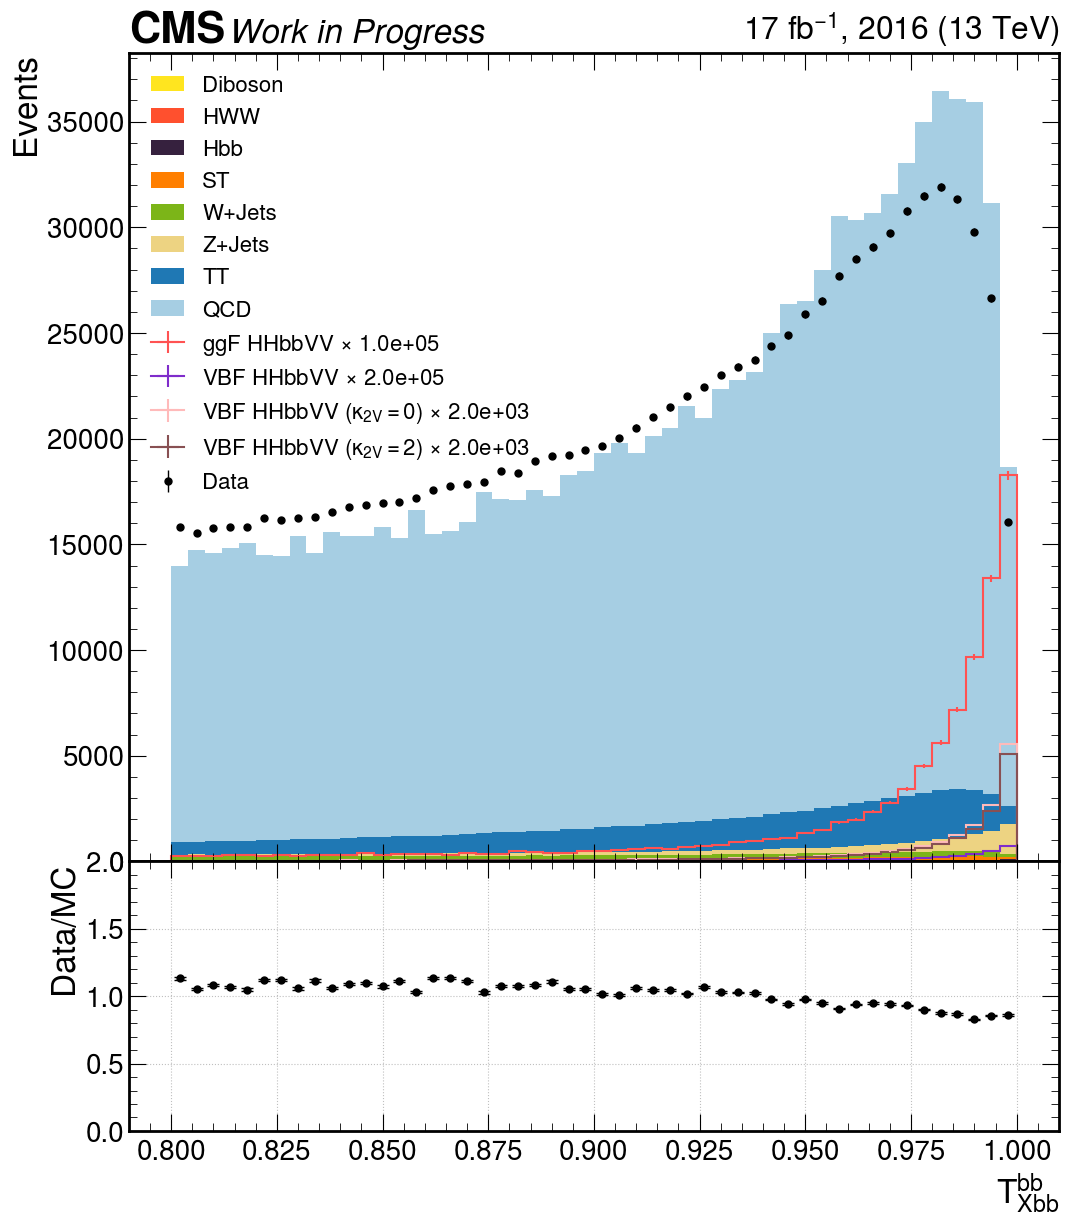

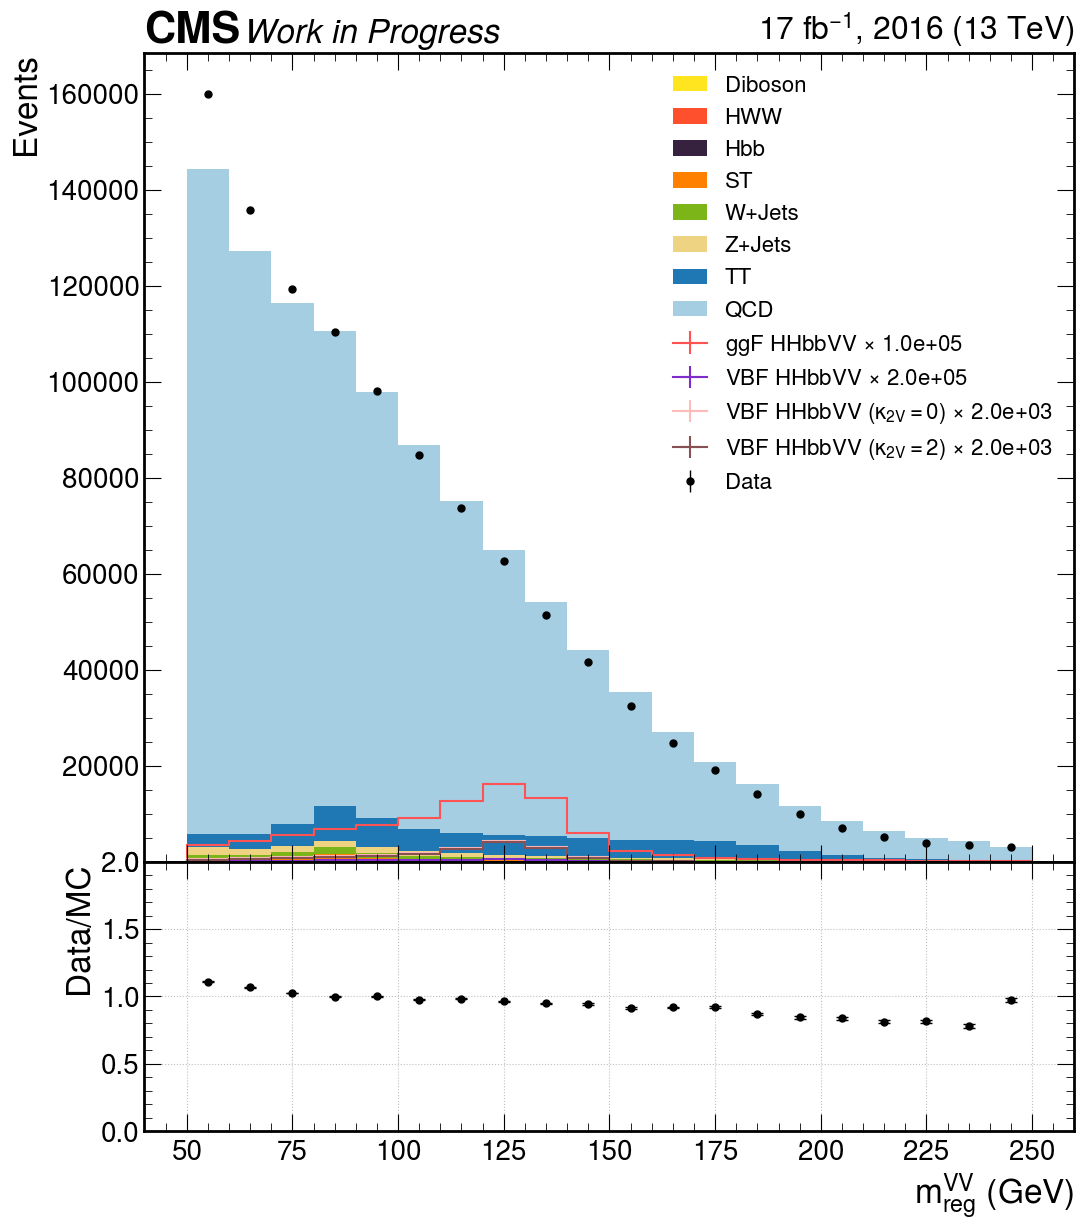

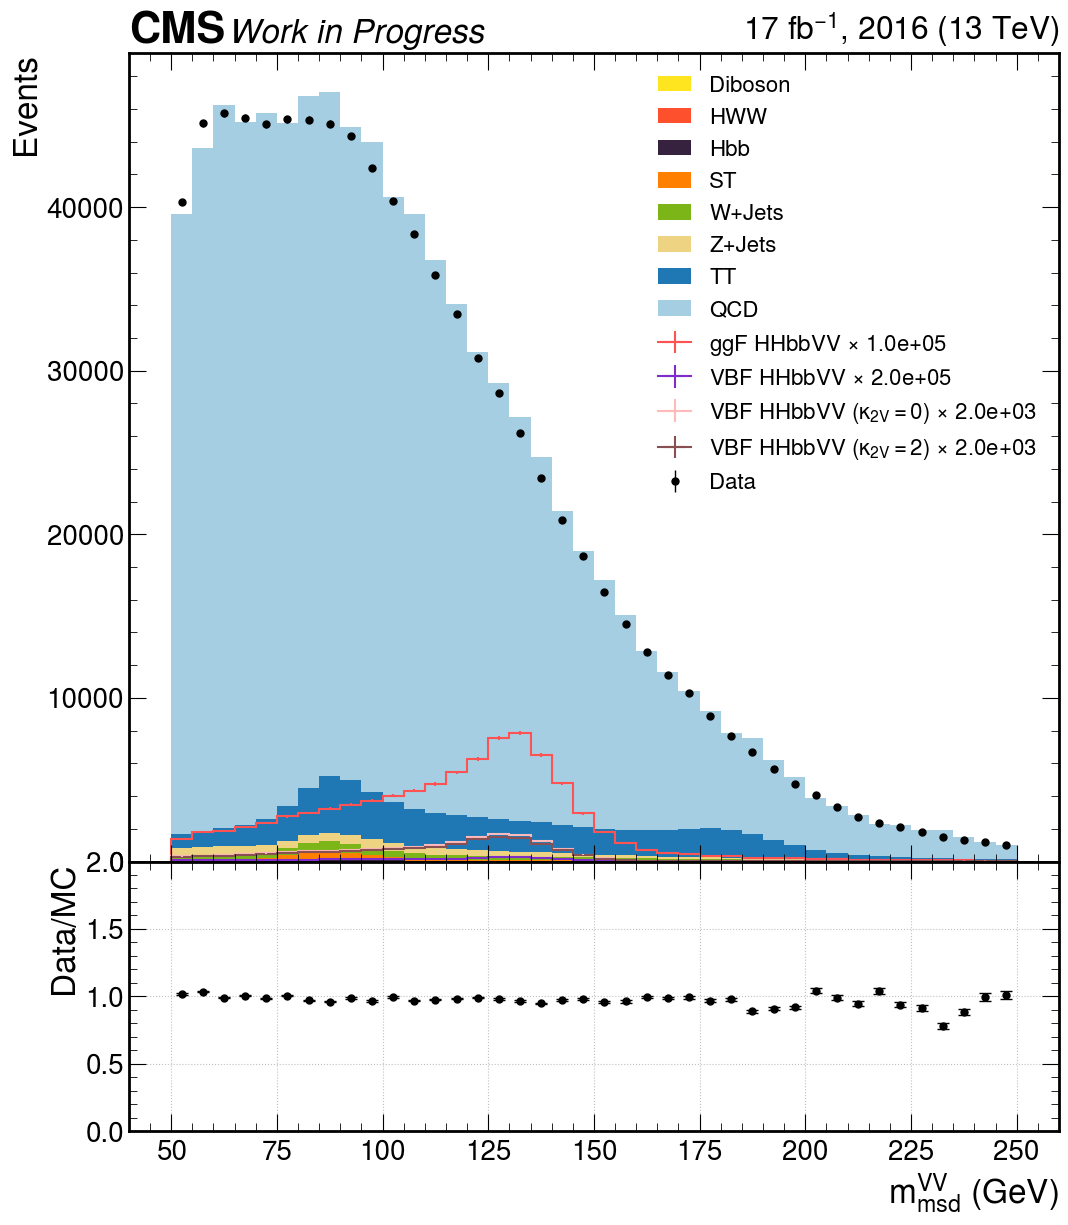

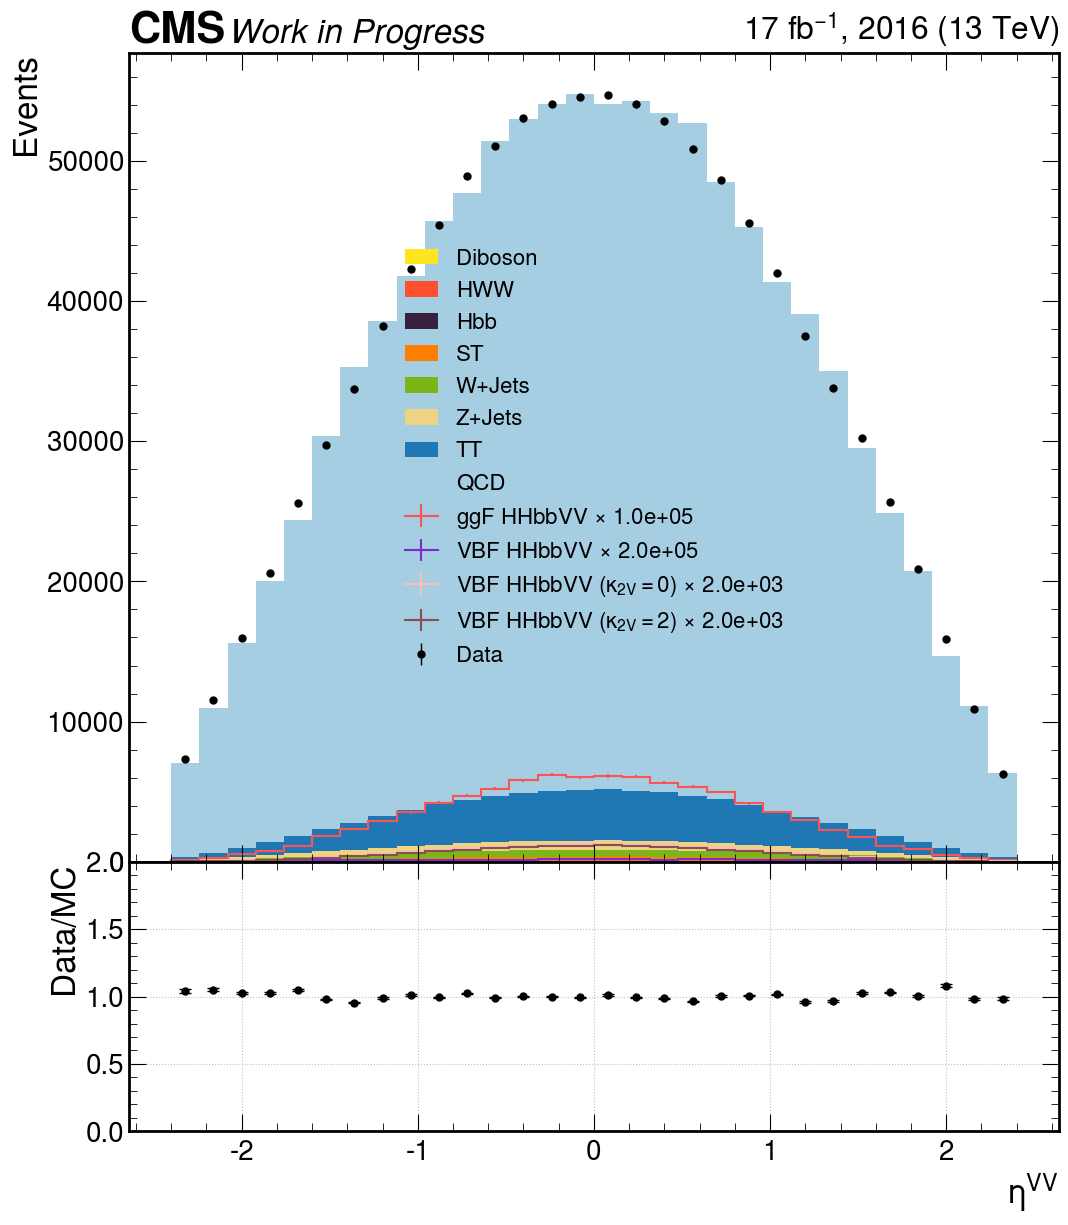

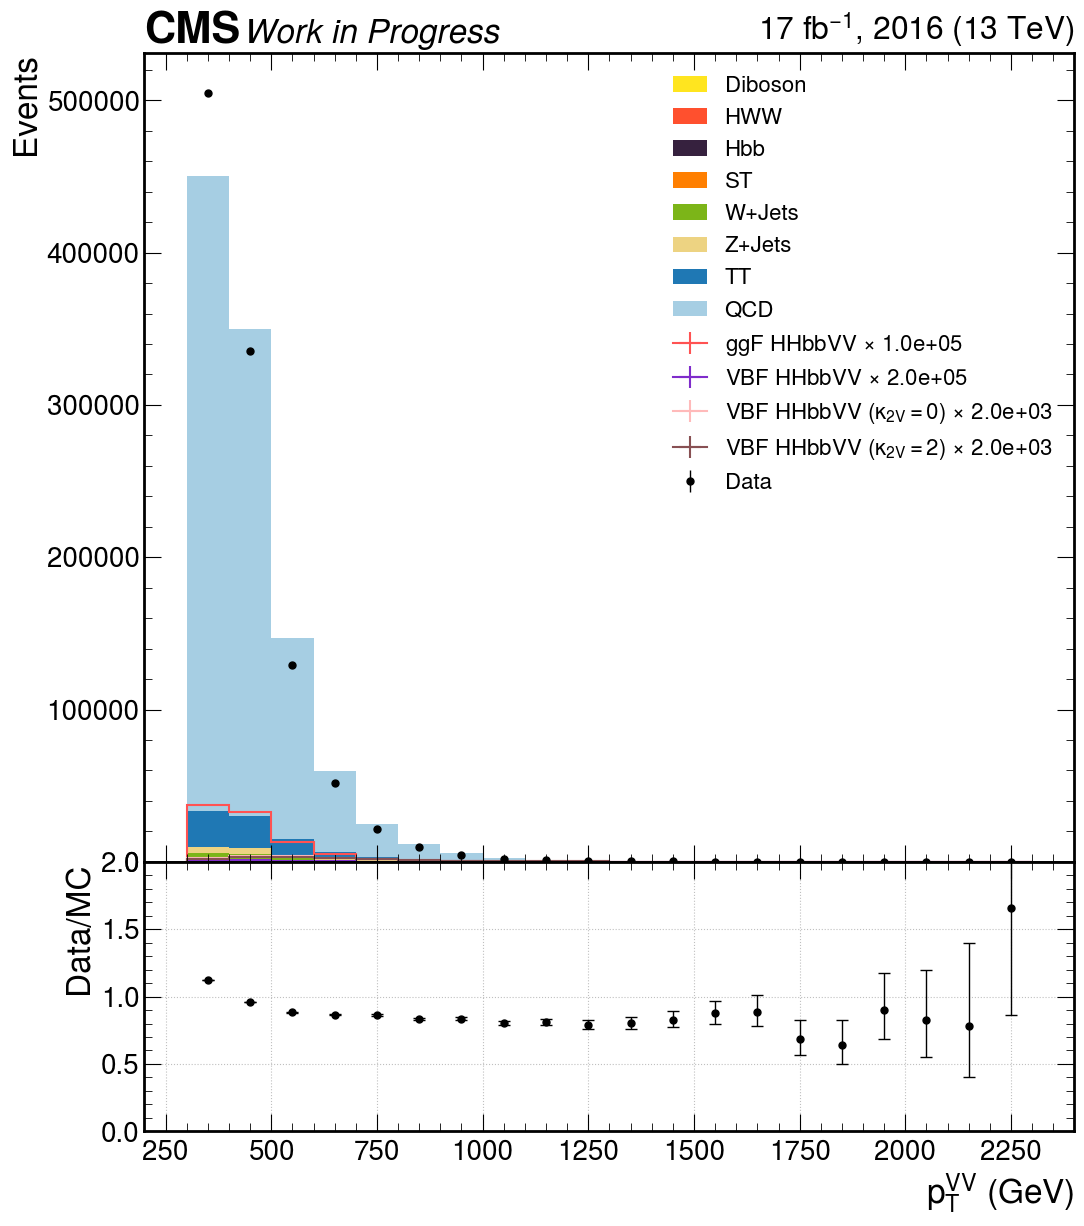

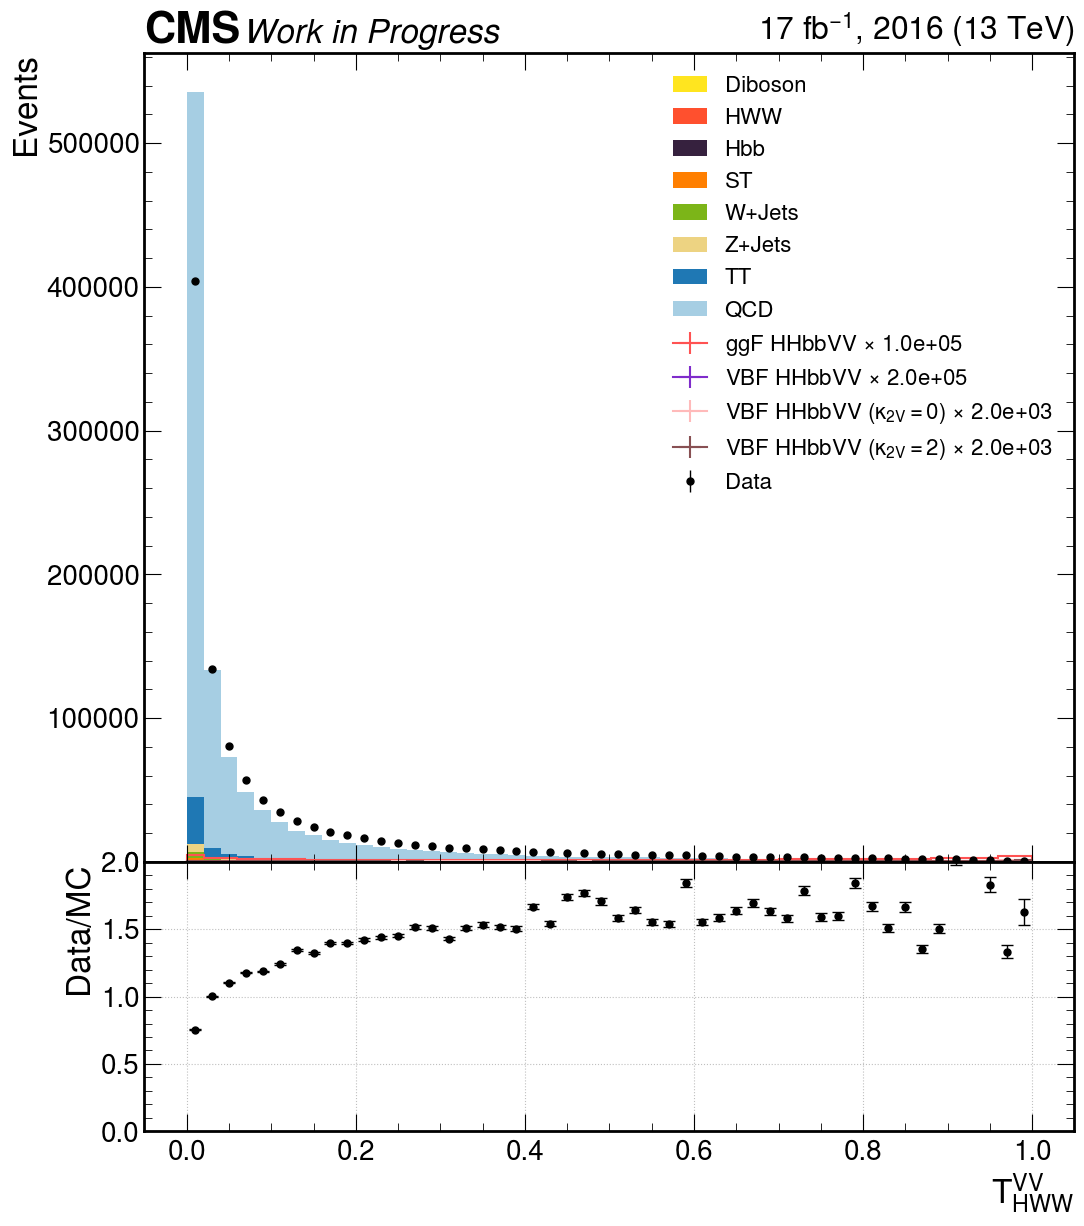

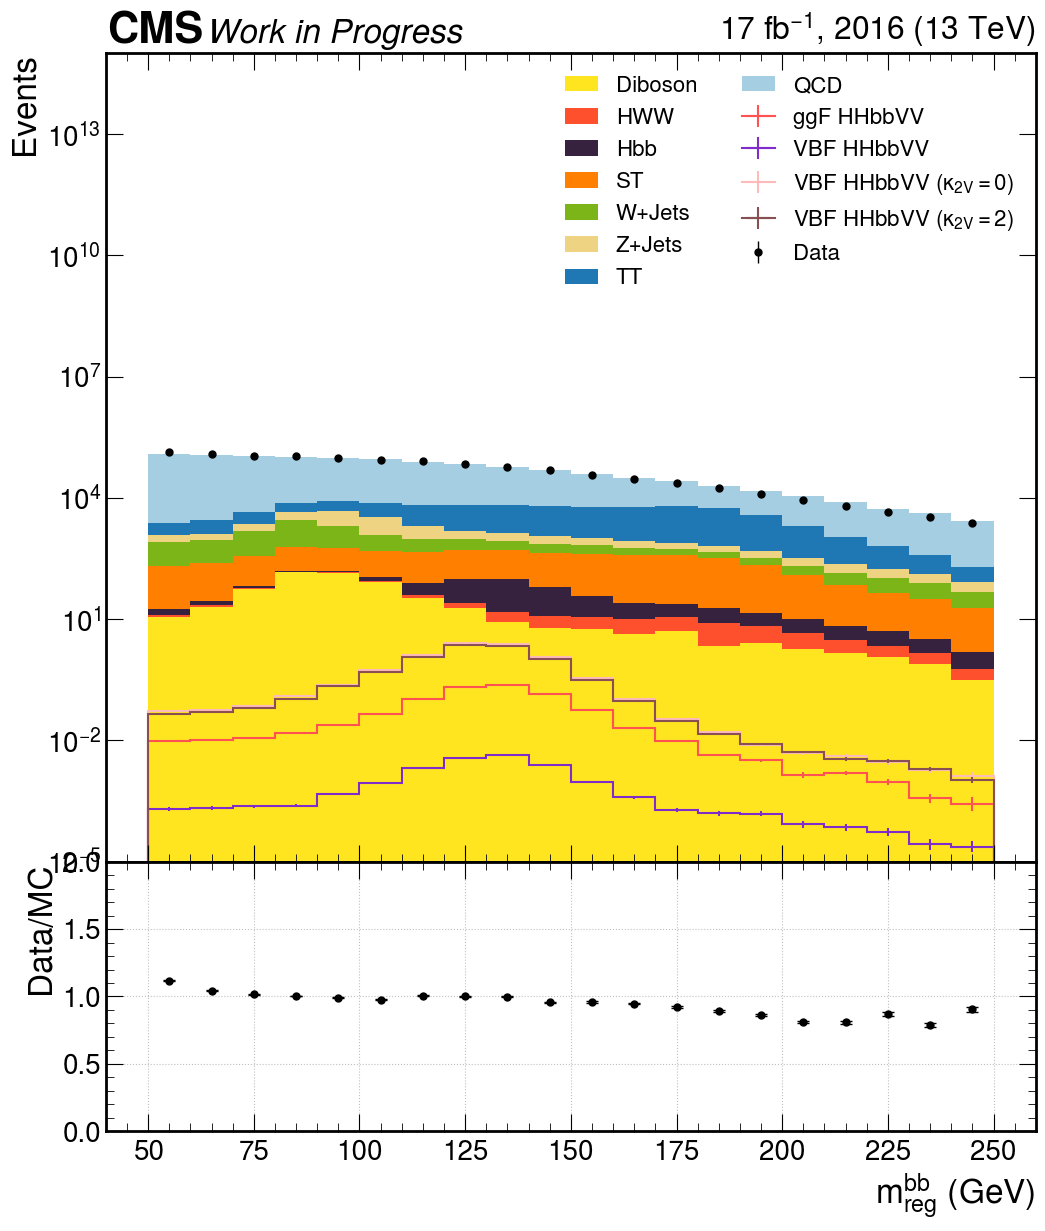

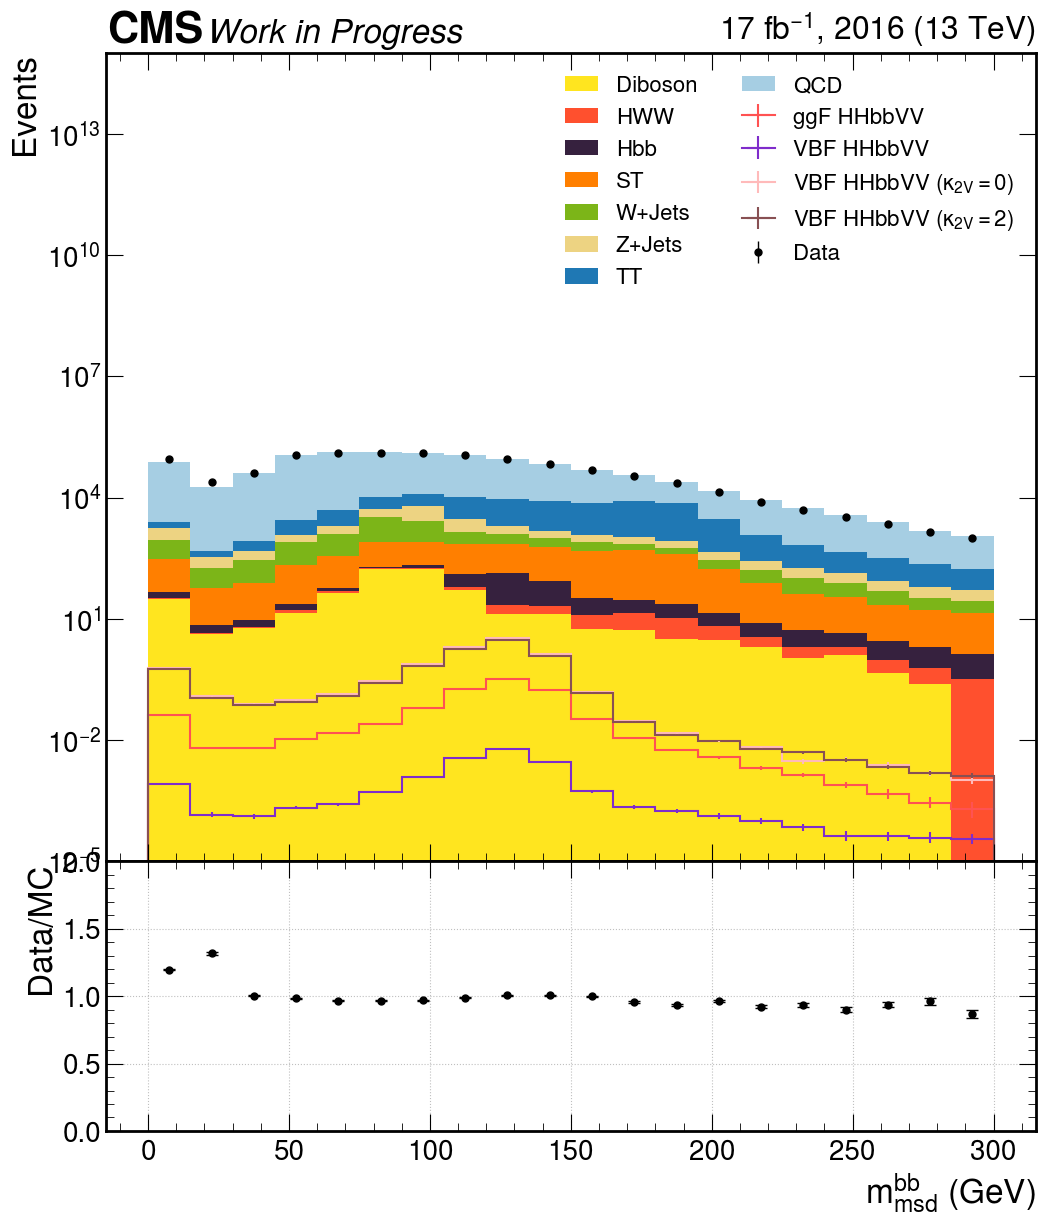

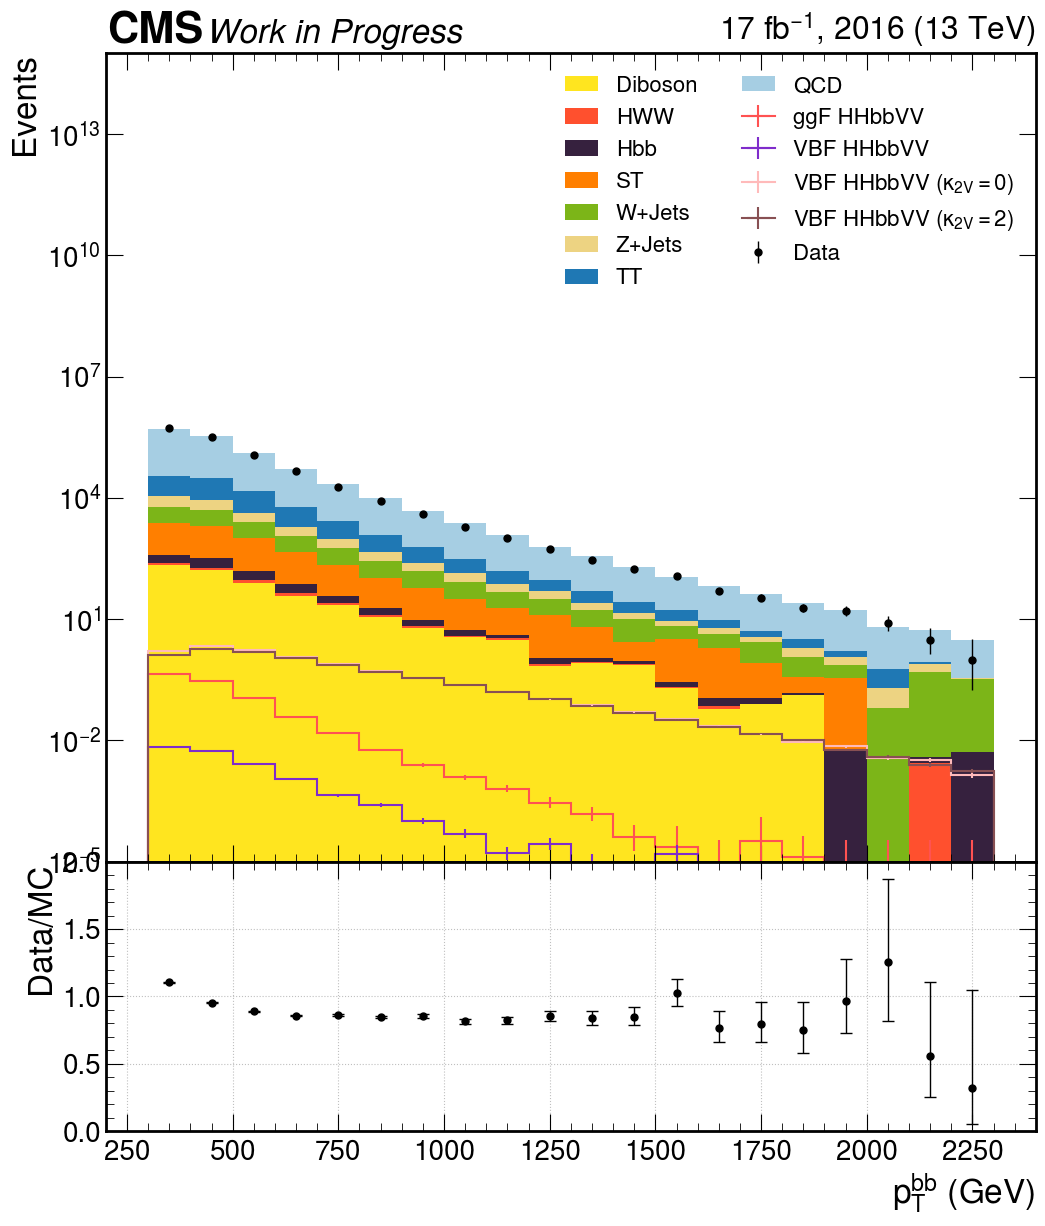

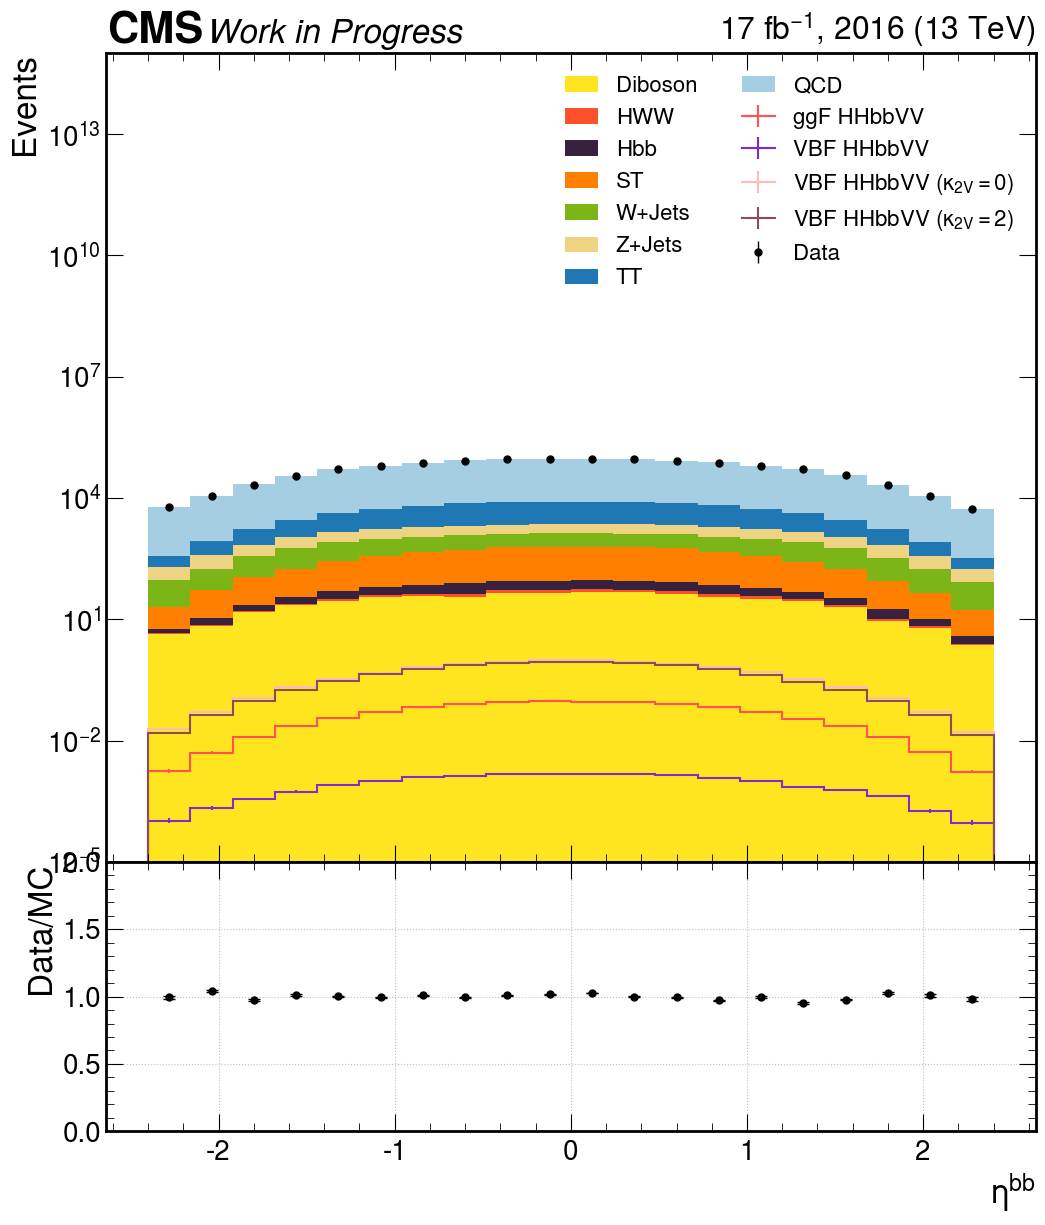

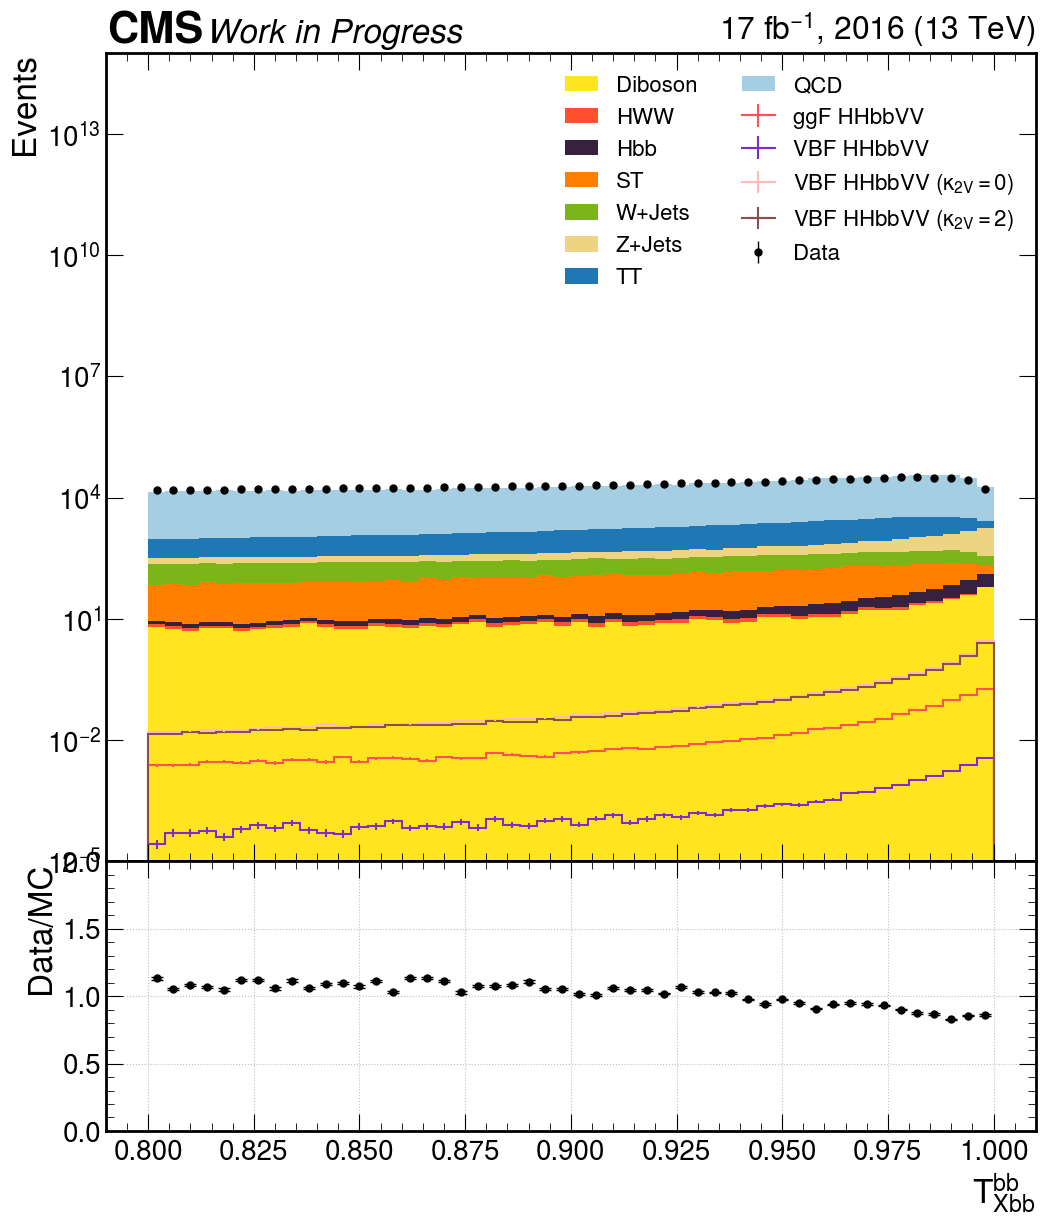

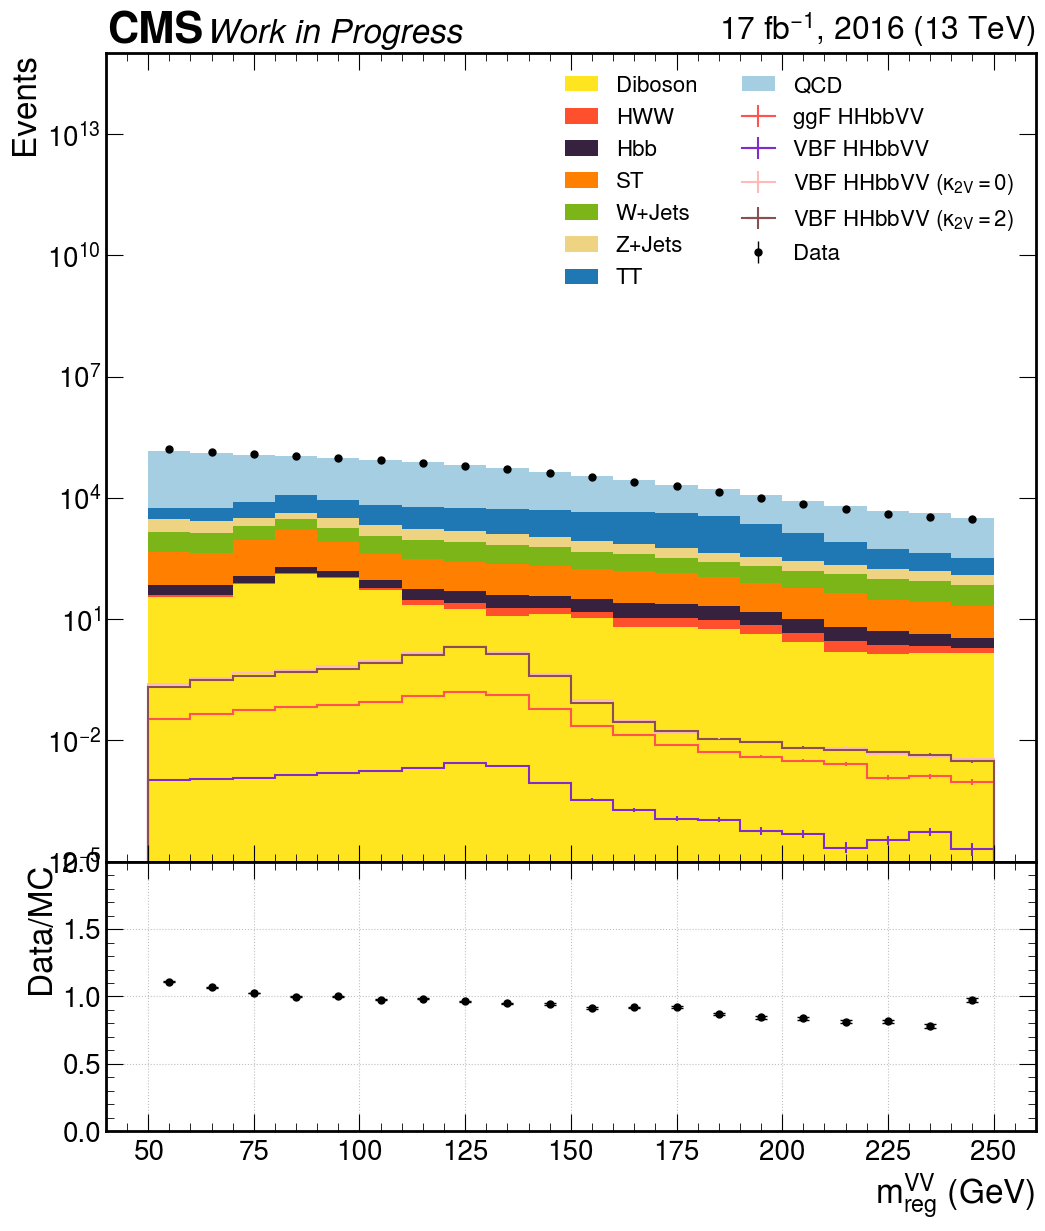

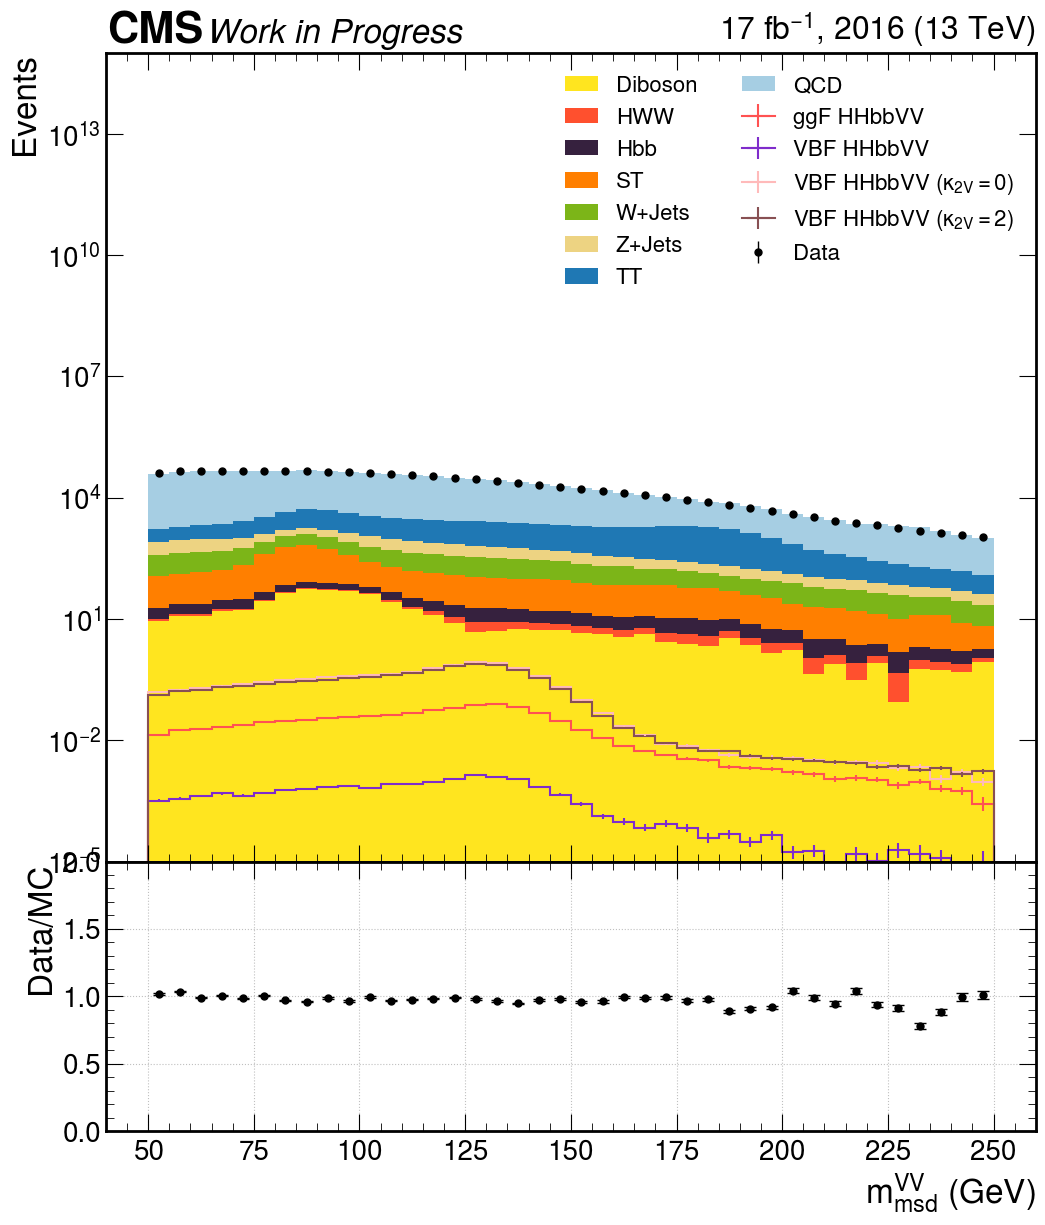

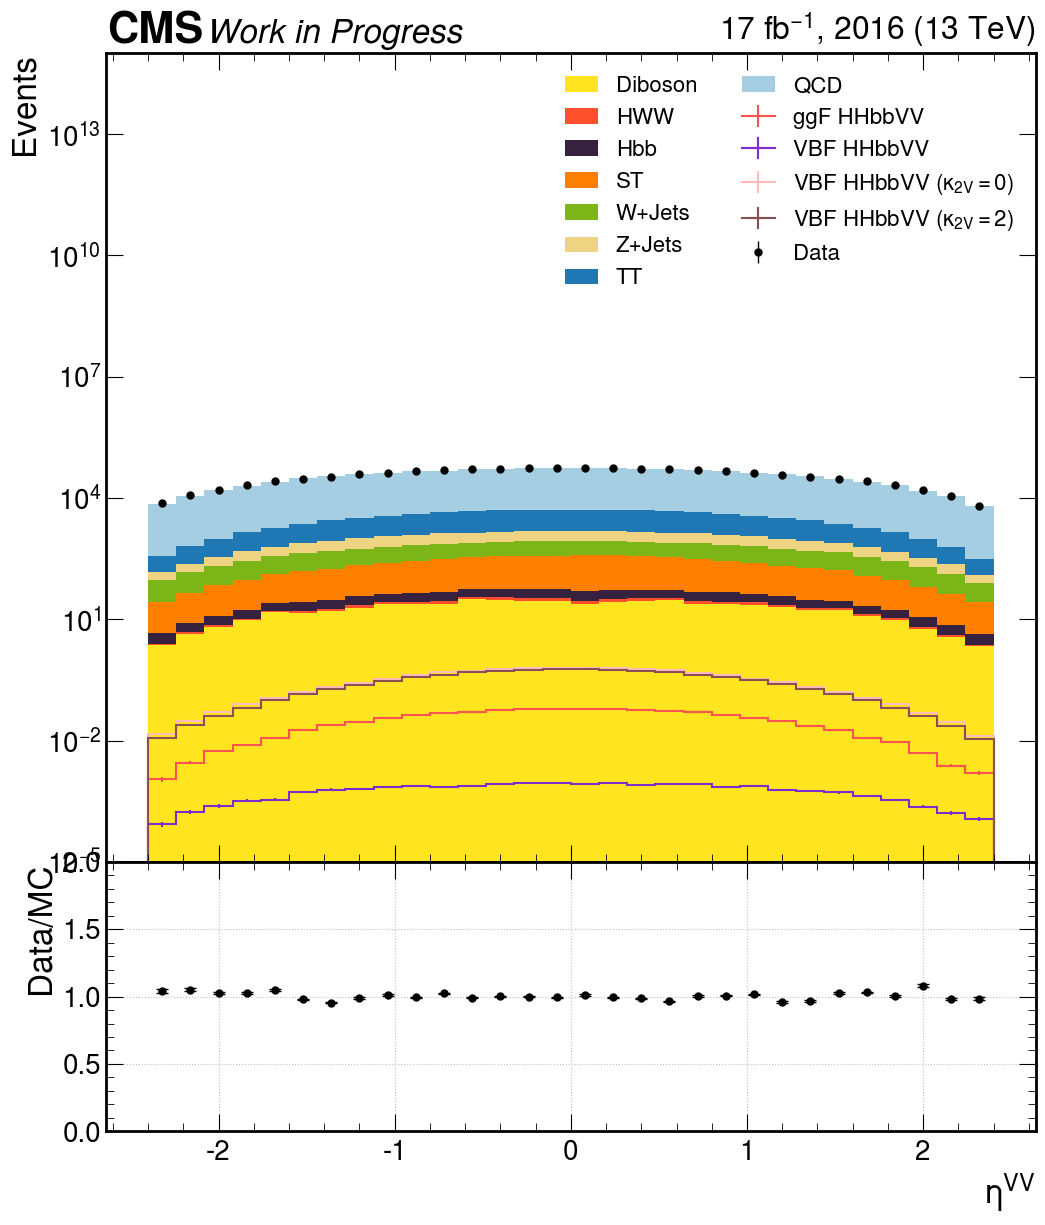

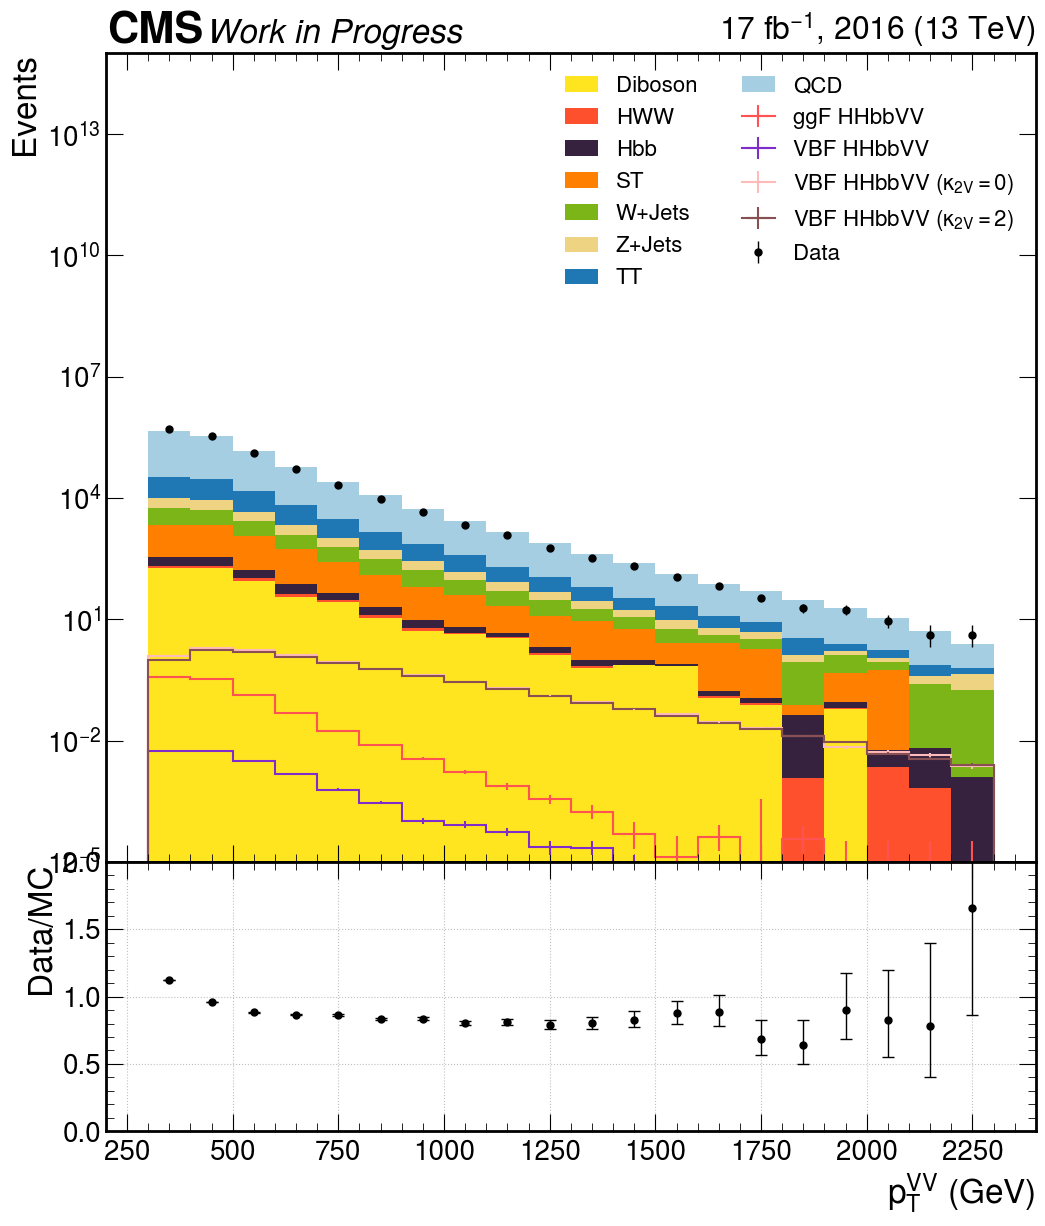

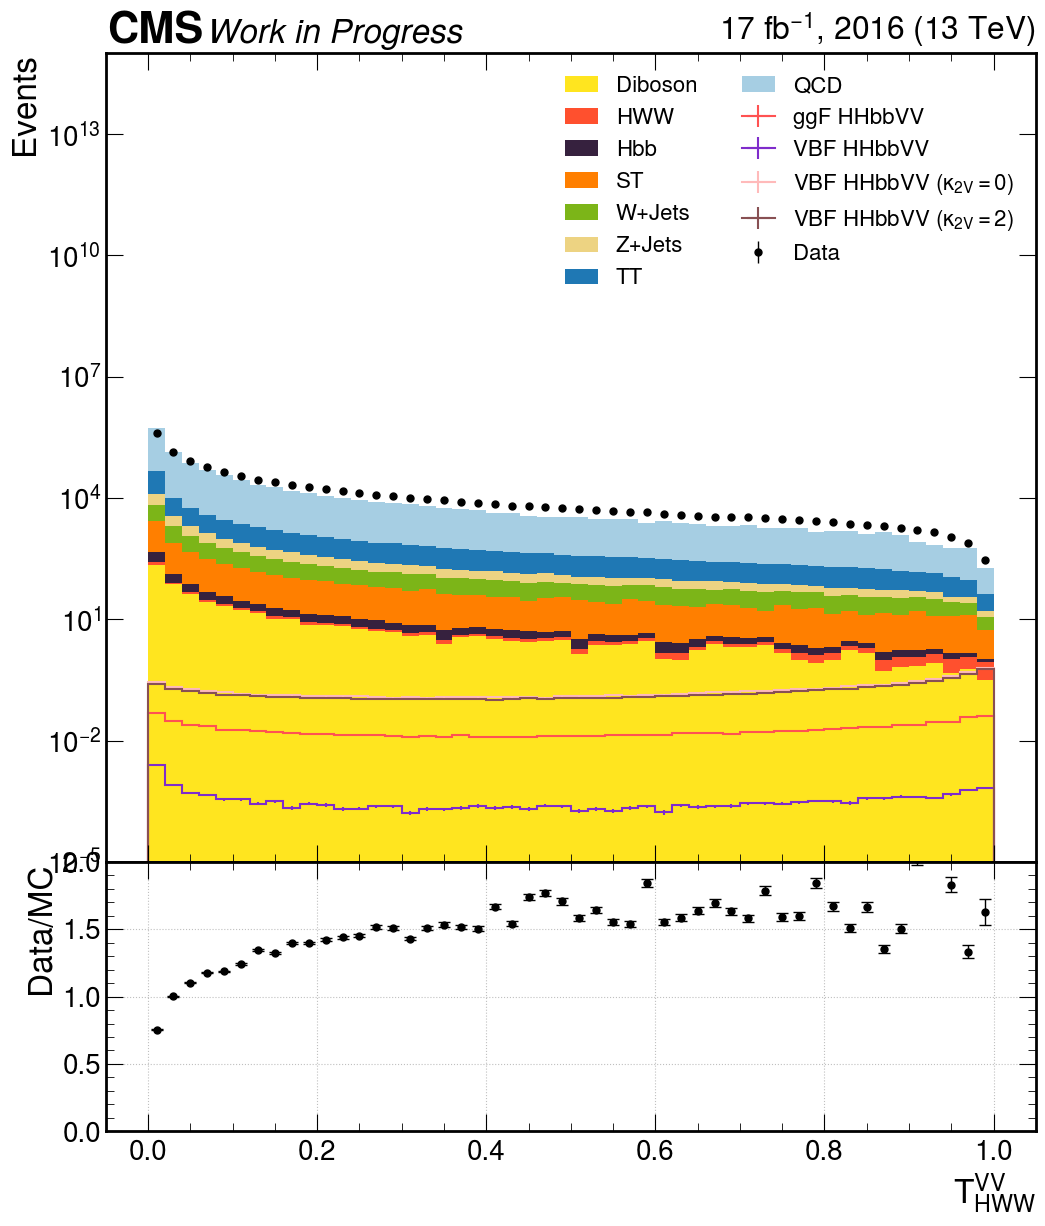

In [7]:
# bb masses, pt, and eta for
# VV fatjet masses, pt, and eta for
# bb particlenet score
# VV parT score
# {var: (bins, label)}
control_plot_vars = [
    # ShapeVar(var="MET_pt", label=r"$p^{miss}_T$ (GeV)", bins=[50, 0, 300]),
    # ShapeVar(var="DijetEta", label=r"$\eta^{jj}$", bins=[30, -8, 8]),
    # ShapeVar(var="DijetPt", label=r"$p_T^{jj}$ (GeV)", bins=[30, 0, 750]),
    # ShapeVar(var="DijetMass", label=r"$m^{jj}$ (GeV)", bins=[30, 600, 4000]),
    ShapeVar(
        var="bbFatJetParticleNetMass",
        label=r"$m^{bb}_{reg}$ (GeV)",
        bins=[20, 50, 250],
        significance_dir="bin",
    ),
    ShapeVar(var="bbFatJetMsd", label=r"$m^{bb}_{msd}$ (GeV)", bins=[20, 0, 300]),
    ShapeVar(
        var="bbFatJetPt", label=r"$p^{bb}_T$ (GeV)", bins=[20, 300, 2300], significance_dir="right"
    ),
    ShapeVar(var="bbFatJetEta", label=r"$\eta^{bb}$", bins=[20, -2.4, 2.4]),
    ShapeVar(var="bbFatJetParticleNetMD_Txbb", label=r"$T^{bb}_{Xbb}$", bins=[50, 0.8, 1]),
    ShapeVar(var="VVFatJetParticleNetMass", label=r"$m^{VV}_{reg}$ (GeV)", bins=[20, 50, 250]),
    ShapeVar(var="VVFatJetMsd", label=r"$m^{VV}_{msd}$ (GeV)", bins=[40, 50, 250]),
    ShapeVar(var="VVFatJetEta", label=r"$\eta^{VV}$", bins=[30, -2.4, 2.4]),
    ShapeVar(var="VVFatJetPt", label=r"$p^{VV}_T$ (GeV)", bins=[20, 300, 2300]),
    ShapeVar(var="VVFatJetParTMD_THWWvsT", label=r"$T^{VV}_{HWW}$", bins=[50, 0, 1]),
    # ShapeVar(var="VVFatJetParticleNet_Th4q", label=r"Prob($H \to 4q$) vs Prob(QCD) (Non-MD)", bins=[50, 0, 1]),
    # ShapeVar(var="VVFatJetParTMD_THWW4q", label=r"Prob($H \to VV \to 4q$) vs Prob(QCD) (Mass-Decorrelated)", bins=[50, 0, 1]),
    # ShapeVar(var="VVFatJetParTMD_probT", label=r"Prob(Top) (Mass-Decorrelated)", bins=[50, 0, 1]),
    # ShapeVar(var="bbFatJetPtOverDijetPt", label=r"$p^{bb}_T / p_T^{jj}$", bins=[50, 0, 40]),
    # ShapeVar(var="VVFatJetPtOverDijetPt", label=r"$p^{VV}_T / p_T^{jj}$", bins=[50, 0, 40]),
    # ShapeVar(var="VVFatJetPtOverbbFatJetPt", label=r"$p^{VV}_T / p^{bb}_T$", bins=[50, 0.4, 2.0]),
    # ShapeVar(var="nGoodMuonsHbb", label=r"# of Muons", bins=[3, 0, 3]),
    # ShapeVar(var="nGoodMuonsHH", label=r"# of Muons", bins=[3, 0, 3]),
    # ShapeVar(var="nGoodElectronsHbb", label=r"# of Electrons", bins=[3, 0, 3]),
    # ShapeVar(var="nGoodElectronsHH", label=r"# of Electrons", bins=[3, 0, 3]),
    # ShapeVar(var="nGoodJets", label=r"# of AK4 B-Jets", bins=[5, 0, 5]),
    # # removed if not ggF nonresonant - needs to be the last variable!
    # ShapeVar(var="BDTScore", label=r"BDT Score", bins=[50, 0, 1]),
]

hists = postprocessing.control_plots(
    events_dict=events_dict,
    bb_masks=bb_masks,
    sig_keys=postprocessing.plot_sig_keys_nonres,
    control_plot_vars=control_plot_vars,
    plot_dir=plot_dir / f"ControlPlots/{year}",
    year=year,
    bg_keys=bg_keys,
    sig_scale_dict={
        "HHbbVV": 1e5,
        "VBFHHbbVV": 2e5,
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 2e3,
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV": 2e3,
    },
    log="both",
    show=True,
)